### Форін Дмитро, Спекторовська Лада, Варіант №11

In [8]:
from sklearn.datasets import load_diabetes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [9]:
data = load_diabetes()
X = data.data
y = data.target
print("General set size: ", X.shape)

General set size:  (442, 10)


### 1) Дані є десятимірними, а не двовимірними тому графічне представлення, в данному випадку, неможливе без значного зниження точності роботи моделі.

### 2) Розбити данi на навчальний, перевiрочний та тестовий набори. Перевiрочний набiр використати для налаштування гiперпараметрiв. Тестовий набiр використати для остаточної оцiнки якостi моделей.

In [10]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
print("Train set size: ", X_train.shape)
print("Validation set size: ", X_val.shape)
print("Test set size: ", X_test.shape)

Train set size:  (264, 10)
Validation set size:  (89, 10)
Test set size:  (89, 10)


### 3) Побудувати ансамблi моделей, згідно з варіантом: GradientBoostingRegressor. Розглянути рiзнi значення learning_rate, subsample, max_features, loss, n_estimators, max_depth.

In [13]:
# Масив для PredefinedSplit: -1 означає "тренувальний набір", 0 — "валідаційний набір"
split_index = [-1] * len(X_train) + [0] * len(X_val)

# Об'єднуємо тренувальні та валідаційні дані
X_train_val_combined = np.vstack((X_train, X_val))
y_train_val_combined = np.hstack((y_train, y_val))

# PredefinedSplit для GridSearchCV
ps = PredefinedSplit(test_fold=split_index)

# Сітка параметрів
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.8, 1.0],
    'max_features': [None, 'sqrt', 'log2'],
    'loss': ['squared_error', 'absolute_error'],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# Ініціалізація моделі
model = GradientBoostingRegressor(random_state=42)

# GridSearchCV із PredefinedSplit
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=ps,  # Використання PredefinedSplit
    verbose=2,
    n_jobs=-1
)

# Навчання моделі
grid_search.fit(X_train_val_combined, y_train_val_combined)

best_model = grid_search.best_estimator_
# Найкращі параметри
print("Best Parameters:", grid_search.best_params_)
print("Best Validation MSE:", -grid_search.best_score_)

Fitting 1 folds for each of 486 candidates, totalling 486 fits
Best Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 50, 'subsample': 0.8}
Best Validation MSE: 52.37693754168035


c:\Users\Lada\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [14]:
y_test_pred = best_model.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_test_pred)
print("Test MSE:", test_rmse)

Test MSE: 52.865529954290515


### 4) Побудувати графiки на однiй координатнiй площинi (для регресiї):
- прогнозiв на основi ансамблю,
- прогнозiв на основi окремої моделi base_estimator / estimators,
- точок даних з перевiрочної / тестової множин.

In [16]:
from sklearn.linear_model import LinearRegression
# Окрема модель LinearRegression
base_model = LinearRegression()
base_model.fit(X_train, y_train)
y_test_pred_base = base_model.predict(X_test)
test_rmse_base = root_mean_squared_error(y_test, y_test_pred_base)
print("Test RMSE (Base Model):", test_rmse_base)


Test RMSE (Base Model): 54.15641293326042


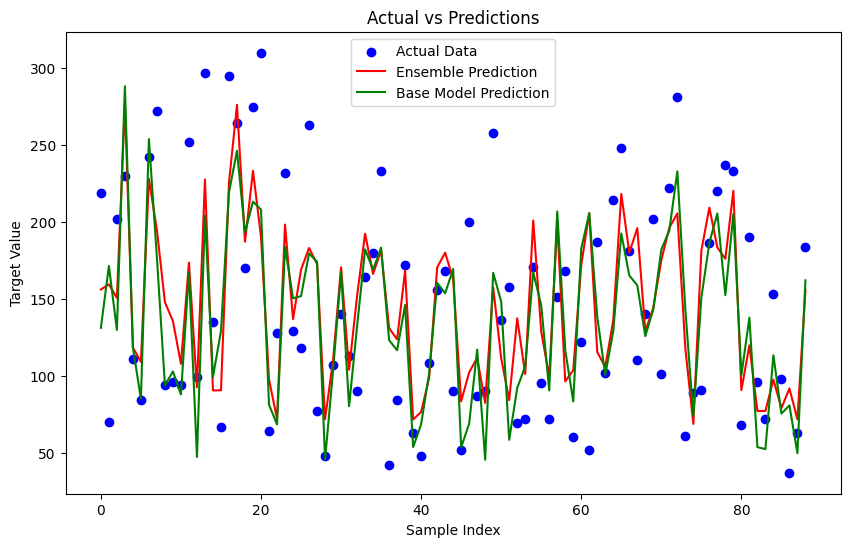

In [18]:
# Побудова графіків
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual Data', color='blue')
plt.plot(range(len(y_test)), y_test_pred, label='Ensemble Prediction', color='red')
plt.plot(range(len(y_test)), y_test_pred_base, label='Base Model Prediction', color='green')
plt.title("Actual vs Predictions")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.legend()
plt.show()


### 5) Розрахувати значення змiщення та дисперсiї для окремої моделi та ансамблю.

In [19]:
# Обчислення зміщення та дисперсії
def bias_variance_decomposition(y_true, y_pred):
    bias = np.mean(y_pred - y_true)
    variance = np.var(y_pred)
    return bias, variance

ensemble_bias, ensemble_variance = bias_variance_decomposition(y_test, y_test_pred)
base_bias, base_variance = bias_variance_decomposition(y_test, y_test_pred_base)

print(f"Ensemble Bias: {ensemble_bias:.4f}, Variance: {ensemble_variance:.4f}")
print(f"Base Model Bias: {base_bias:.4f}, Variance: {base_variance:.4f}")

Ensemble Bias: -0.5067, Variance: 2535.3582
Base Model Bias: -7.8748, Variance: 2921.5670


### 6) Що можна сказати про час навчання ансамблю порiвняно з окремими моделями, якi утворюють цi ансамблi?

In [20]:
# Час навчання ансамблю порівняно з базовою моделлю
import time

start_time = time.time()
model.fit(X_train_val_combined, y_train_val_combined)
ensemble_training_time = time.time() - start_time

start_time = time.time()
base_model.fit(X_train, y_train)
base_training_time = time.time() - start_time

print(f"Training Time (Ensemble): {ensemble_training_time:.2f} seconds")
print(f"Training Time (Base Model): {base_training_time:.2f} seconds")

Training Time (Ensemble): 0.17 seconds
Training Time (Base Model): 0.00 seconds


Час навчання ансамблевих моделей довший, ніж для окремих моделей, але в обмін на це ансамблі забезпечують вищу точність, меншу дисперсію та кращу узагальнюючу здатність на тестових наборах. Це робить ансамблі доцільними для більш складних завдань, незважаючи на їхню обчислювальну складність.

### 7. Зробити висновки. Чи краще на заданих даних виконується ансамбль порiвняно з iндивiдуальними моделями?

### **Висновки:**  

1. **Точність моделі:**  
   - Ансамблева модель 'GradientBoostingRegressor' показала **нижчий RMSE на тестовому наборі** порівняно з базовою моделлю 'LinearRegression'. Це свідчить про **кращу точність прогнозів** ансамблю.  

2. **Зміщення та дисперсія:**

   -Ансамбль має менше зміщення (за абсолютним значенням): -0.5067 проти -7.8748. Це означає, що прогнози ансамблю ближчі до реальних значень у середньому.
   -Дисперсія ансамблю також нижча (2535.3582 проти 2921.5670), що свідчить про стабільність його прогнозів і меншу схильність до перенавчання.

3. **Графіки прогнозів:**  
   - На основі графіка видно, що ансамбль (GradientBoostingRegressor) забезпечує більш гладкі і стабільні прогнози в порівнянні з базовою моделлю (LinearRegression). Хоча обидві моделі добре слідують за трендом, ансамбль показує меншу схильність до сильних коливань, що вказує на його здатність краще узагальнювати дані.

4. **Час навчання:**  
   - Ансамблева модель вимагає більше часу на навчання через складність методів і багаторазові ітерації. Базова модель LinearRegression є швидшою, але програє у точності.  

5. **Загальна продуктивність:**  
   - **Ансамбль працює краще** на заданих даних завдяки своїй здатності моделювати складні, нелінійні залежності. Однак його використання виправдане лише за наявності достатніх обчислювальних ресурсів.  

**Висновок:**  
Ансамбль (GradientBoostingRegressor) на заданих даних демонструє кращу продуктивність, ніж базова модель (LinearRegression), завдяки меншому зміщенню, нижчій дисперсії і стабільності прогнозів. Це робить ансамблі ефективнішим вибором для задач, де потрібна висока точність.